In [1]:
import datetime
from data.polygon import get_aggregate_bars
from data.polygon import _get_aggregate_bars
import polars_quant_expressions
import polars as pl

pl.Config.set_tbl_rows(n=10)
pl.Config.set_tbl_rows(n=20)

EQUITIES = ['AAPL', 'IBM', 'AMZN', 'MSFT']
BENCHMARK = ['I:NDX']

#### Get Daily Bar Data from Polygon

In [2]:
df = get_aggregate_bars( 
    tickers=EQUITIES + BENCHMARK, 
    multiplier=1,
    timespan='day',
    from_=datetime.date(2025, 1, 1),
    to=datetime.date(2025, 10, 13)
)

#### Returns

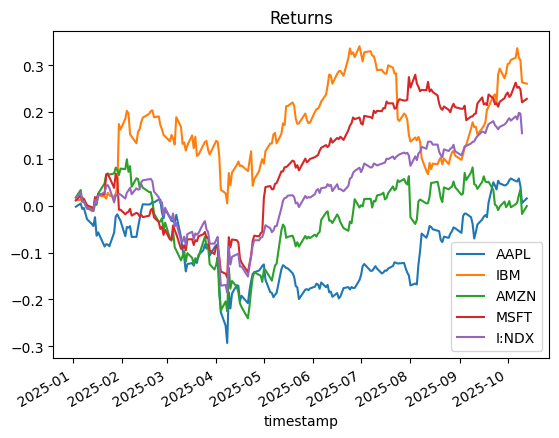

In [3]:
# Compute returns
returns_df = df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('close').quant.returns(periods=1, over='ticker')
])

# Collect to eager DataFrame and pivot
_returns_df = returns_df.collect().pivot(
    values='return',
    index='timestamp',
    on='ticker'
)

# Plot
_returns_df.to_pandas().set_index('timestamp').add(1).cumprod().sub(1).plot(title='Returns');

#### Rolling Vol

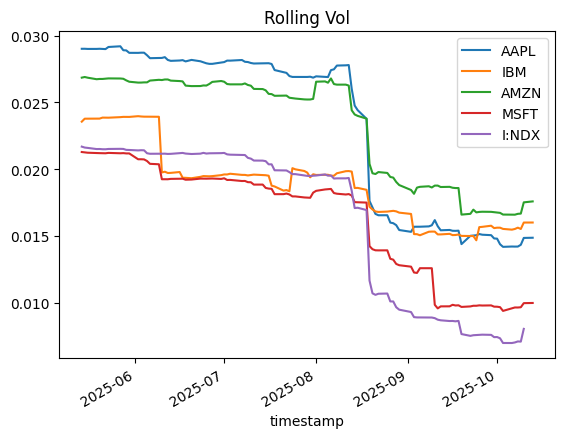

In [4]:
# Compute rolling volatility
vol_df = returns_df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('return').quant.rolling_vol(over='ticker', window_size=90, min_samples=90)
])

# Collect to eager DataFrame and pivot
_vol_df = vol_df.collect().pivot(
    values='rolling_vol',
    index='timestamp',
    on='ticker'
)

# Plot
_vol_df.to_pandas().set_index('timestamp').plot(title='Rolling Vol');

#### Rolling Betas

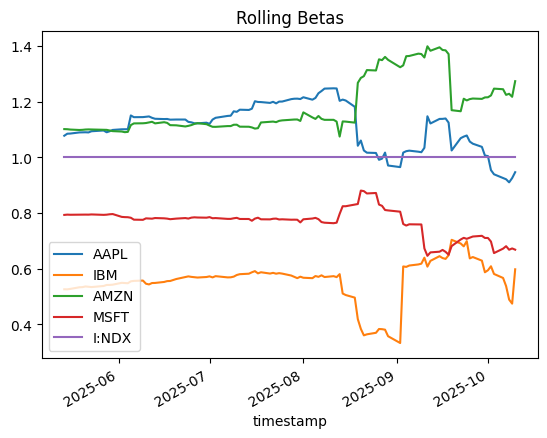

In [7]:
# Separate and merge benchmark returns
benchmark_returns_df = (
    returns_df.filter(pl.col('ticker') == BENCHMARK[0])
    .select(['timestamp', 'return'])
    .rename({'return': 'benchmark_return'})
)
returns_join_df = returns_df.join(other=benchmark_returns_df, on='timestamp', how='inner')

betas_df = returns_join_df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('return').quant.rolling_beta(pl.col('benchmark_return'), window_size=90, over='ticker')
])

_betas_df = betas_df.collect().pivot(
    values='rolling_beta',
    index='timestamp',
    on='ticker'
)

_betas_df.to_pandas().set_index(keys='timestamp').plot(title='Rolling Betas');